# Multi-Swarm PSO Optimization

This notebook demonstrates the multi-swarm PSO optimization functionality for the Transit Network Frequency Setting Problem (TNFSP). PSO is stochastic and dependant on the initialization, so results may vary between runs. The idea behind a multi-swarm approach is to run several swarms in parallel, each exploring different regions of the solution space. This can help avoid local minima and improve the chances of finding a global optimum (or at least a better local optimum).

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from typing import Dict, Any
import logging

# Add src to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

## 1 Data Setup and Problem Configuration

We set up the problem configuration as in previous notebooks. This includes
- Loading in the GTFS feed and preprocessing it
- Setting up the objective function and constraints
- Defining a spatial boundary for the optimization (cropping to a specific area)
- Adding the configs for the PSO problem



In [2]:
# =============================================================================
# Data Setup and Problem Configuration
# =============================================================================

from transit_opt.preprocessing.prepare_gtfs import GTFSDataPreparator
from transit_opt.optimisation.spatial.boundaries import StudyAreaBoundary

print("=== LOADING GTFS DATA ===")

# Create GTFS preparator
preparator = GTFSDataPreparator(
    gtfs_path='../data/external/study_area_gtfs_bus.zip',
    interval_hours=6,  # 4 periods per day
    date=None,  # Use full GTFS feed (you should specify a date if your feed has multiple days)
    turnaround_buffer=1.15,  # 15% buffer
    max_round_trip_minutes=240.0,  # Maximum round-trip time
    no_service_threshold_minutes=480.0,  # Threshold for no-service mapping
    log_level="INFO"
)

# Define allowed headways for optimization
allowed_headways = [10, 15, 30, 60, 120, 240] # in minutes

print(f"📋 Allowed headways: {allowed_headways} minutes")
print("🔄 Extracting optimization data...")

# Extract optimization data structure
opt_data = preparator.extract_optimization_data(allowed_headways)

print(f"\n✅ GTFS DATA PROCESSED:")
print(f"   📊 Routes: {opt_data['n_routes']}")
print(f"   ⏰ Time intervals: {opt_data['n_intervals']} (6h each)")
print(f"   🎯 Decision variables: {opt_data['decision_matrix_shape'][0]} × {opt_data['decision_matrix_shape'][1]} = {np.prod(opt_data['decision_matrix_shape'])}")
print(f"   🚗 Current peak fleet: {opt_data['constraints']['fleet_analysis']['total_current_fleet_peak']} vehicles")
print(f"   🔢 Headway choices: {opt_data['n_choices']} (including no-service)")

2025-10-15 15:07:13,147 - transit_opt.preprocessing.prepare_gtfs - INFO - Initializing GTFSDataPreparator with 6h intervals
2025-10-15 15:07:13,148 - transit_opt.preprocessing.prepare_gtfs - INFO - Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip


=== LOADING GTFS DATA ===


2025-10-15 15:07:15,264 - transit_opt.preprocessing.prepare_gtfs - INFO - Using full GTFS feed (all service periods)
2025-10-15 15:07:16,549 - transit_opt.preprocessing.prepare_gtfs - INFO - GTFS loaded and cached in 3.40 seconds
2025-10-15 15:07:16,550 - transit_opt.preprocessing.prepare_gtfs - INFO - Dataset: 13,974 trips, 703,721 stop times
2025-10-15 15:07:16,550 - transit_opt.preprocessing.prepare_gtfs - INFO - Extracting optimization data with 6 allowed headways
2025-10-15 15:07:16,551 - transit_opt.preprocessing.prepare_gtfs - INFO - Extracting route essentials with 6-hour intervals


📋 Allowed headways: [10, 15, 30, 60, 120, 240] minutes
🔄 Extracting optimization data...


2025-10-15 15:07:17,474 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 73302: Round-trip 317.4min exceeds limit (240.0min), filtered out
2025-10-15 15:07:17,502 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 54721: Round-trip 366.8min exceeds limit (240.0min), filtered out
2025-10-15 15:07:18,631 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 30922: Round-trip 247.2min exceeds limit (240.0min), filtered out
2025-10-15 15:07:19,329 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 12490: Round-trip 416.3min exceeds limit (240.0min), filtered out
2025-10-15 15:07:19,392 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 37599: Round-trip 355.3min exceeds limit (240.0min), filtered out
2025-10-15 15:07:21,062 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 59129: Round-trip 396.7min exceeds limit (240.0min), filtered out
2025-10-15 15:07:23,660 - transit_opt.preprocessing.prepare_gtfs - WARNING - Route 73828: Round-trip 258.8


✅ GTFS DATA PROCESSED:
   📊 Routes: 147
   ⏰ Time intervals: 4 (6h each)
   🎯 Decision variables: 147 × 4 = 588
   🚗 Current peak fleet: 1250 vehicles
   🔢 Headway choices: 7 (including no-service)


In [3]:
# Load boundary geometry
boundary_gdf = gpd.read_file("../data/external/boundaries/study_area_boundary.geojson")
print(f"📍 Loaded boundary with {len(boundary_gdf)} feature(s)")

# Create study area boundary with buffer
study_boundary = StudyAreaBoundary(
    boundary_gdf=boundary_gdf,
    crs="EPSG:3857",  # Web Mercator for spatial analysis
    buffer_km=2.0     # 2km buffer around boundary
)

print(f"✅ Study area boundary created:")
print(f"   📐 CRS: {study_boundary.target_crs}")
print(f"   📏 Buffer: 2km")

📍 Loaded boundary with 2607 feature(s)
✅ Validated metric CRS: EPSG:3857
🔄 Converting boundary CRS: EPSG:4326 → EPSG:3857
📏 Applied 2.0km buffer
✅ Study area set: 1 polygon(s) in EPSG:3857
✅ Study area boundary created:
   📐 CRS: EPSG:3857
   📏 Buffer: 2km


### Setup Objective Function


In [4]:
from transit_opt.optimisation.objectives import HexagonalCoverageObjective

print("\n=== OBJECTIVE FUNCTION SETUP ===")
print("Using Hexagonal Coverage Objective for multi-swarm demonstration")
print("• Minimizes variance in spatial service distribution")
print("• Good test case for multi-swarm robustness")

# Create coverage objective
coverage_objective = HexagonalCoverageObjective(
    optimization_data=opt_data,
    spatial_resolution_km=3.0,
    crs="EPSG:3857",
    boundary=study_boundary,
    spatial_lag=True,
    alpha=0.2
)

print(f"\n📍 Spatial System:")
print(f"   🔸 Hexagonal zones: {len(coverage_objective.spatial_system.hex_grid)}")
print(f"   🚏 Transit stops (filtered): {len(coverage_objective.spatial_system.stops_gdf)}")
print(f"   📐 Zone size: ~{3.0} km diameter hexagons")

# Evaluate baseline performance
current_objective_value = coverage_objective.evaluate(opt_data['initial_solution'])
current_analysis = coverage_objective.get_detailed_analysis(opt_data['initial_solution'])

print(f"\n🎯 BASELINE PERFORMANCE:")
print(f"   Objective value (variance): {current_objective_value:.6f}")
print(f"   Zones with service: {current_analysis['zones_with_service_average']}")
print(f"   Mean vehicles per zone: {current_analysis['total_vehicles_average']:.1f}")
print(f"   Coefficient of variation: {current_analysis['coefficient_of_variation_average']:.3f}")


=== OBJECTIVE FUNCTION SETUP ===
Using Hexagonal Coverage Objective for multi-swarm demonstration
• Minimizes variance in spatial service distribution
• Good test case for multi-swarm robustness
🗺️ Setting up spatial analysis with 3.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🎯 Applying boundary filter to 6897 stops...
🔍 Filtered 6897 → 4405 points
✅ Filtered to 4405 stops within boundary
🔧 Creating 18 × 18 = 324 grid cells
   Grid bounds: (-195846, 7111259) to (-142157, 7162476) meters
   Cell size: 3000.0m × 3000.0m
✅ Created 324 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 324 grid cells...
🔍 Filtered 324 → 251 grid cells
✅ Filtered to 251 grid cells within boundary
✅ Created 251 hexagonal zones in EPSG:3857
🚀 Using spatial join for zone mapping...
✅ Mapped 4405 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 187 routes
✅ Spatial system ready: 251 hexagonal zones, spatial lag (α=0.2)

📍 Spatial System:
   🔸 Hexagonal zones: 251
   🚏

### Configs for Single PSO and Multi-Swarm PSO

The config for the single swarm PSO is the same as in previous notebooks. The multi-swarm config extends this with additional parameters.

In our base configuration, we can decide whether to use HARD constraints (which must be satisfied for a solution to be feasible) or SOFT constraints (which are added as penalties to the objective function). Here, we use SOFT constraints.

In [5]:
print("\n=== SINGLE vs MULTI-SWARM CONFIGURATION ===")
print("🔧 We'll compare single PSO run vs multi-swarm approach")

# Base configuration for both approaches
base_config = {
    'problem': {
        'objective': {
            'type': 'HexagonalCoverageObjective',
            'spatial_resolution_km': 3.0,
            'crs': 'EPSG:3857',
            'boundary_file': '../data/external/boundaries/study_area_boundary.geojson',
            'boundary_buffer_km': 2.0
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.25,  # 25% increase allowed
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.8,  # Maintain 80% of current service
                'level': 'system',
                'measure': 'peak', 
                'baseline': 'current_peak'
            }
        ],
        'penalty_weights': {
            'fleet_total': 10.0,
            'minimum_fleet': 20.0
        }
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 30,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': True,
            'penalty_weight': 15.0,
            'adaptive_penalty': False
        },
        'termination': {
            'max_generations': 25
        },
        'monitoring': {
            'progress_frequency': 5,
            'save_history': True,
            'detailed_logging': True
        }
    }
}

# Multi-swarm configuration
multi_swarm_config = {
    'n_runs': 8,  # Number of independent swarms
    'parallel': True,  # Use parallel processing
    'comparison_metrics': ['best_objective', 'feasibility_rate', 'convergence_speed']
}

print(f"🎯 OPTIMIZATION SETUP:")
print(f"   Population per swarm: {base_config['optimization']['algorithm']['pop_size']}")
print(f"   Generations: {base_config['optimization']['termination']['max_generations']}")
print(f"   Constraint handling: Penalty method")
print(f"   Constraints: {len(base_config['problem']['constraints'])}")

for i, constraint in enumerate(base_config['problem']['constraints'], 1):
    constraint_type = constraint['type'].replace('ConstraintHandler', '')
    tolerance = constraint.get('tolerance', constraint.get('min_fleet_fraction', 'N/A'))
    print(f"     {i}. {constraint_type}: {tolerance}")


=== SINGLE vs MULTI-SWARM CONFIGURATION ===
🔧 We'll compare single PSO run vs multi-swarm approach
🎯 OPTIMIZATION SETUP:
   Population per swarm: 30
   Generations: 25
   Constraint handling: Penalty method
   Constraints: 2
     1. FleetTotal: 0.25
     2. MinimumFleet: 0.8


## Single PSO run vs Multi-Swarm PSO run

In [6]:
# =============================================================================
# Single PSO Run (Baseline)
# =============================================================================

from transit_opt.optimisation.config.config_manager import OptimizationConfigManager
from transit_opt.optimisation.runners.pso_runner import PSORunner

print("\n🚀 SINGLE PSO RUN (BASELINE)")
print("Running single PSO optimization for comparison...")

# Create and run single PSO
config_manager_single = OptimizationConfigManager(config_dict=base_config)
pso_runner_single = PSORunner(config_manager_single)

# Run single optimization
single_result = pso_runner_single.optimize(opt_data, track_best_n=10)

print(f"\n✅ SINGLE PSO COMPLETED")
print(f"⏱️  Runtime: {single_result.optimization_time:.1f} seconds")
print(f"📊 Generations: {single_result.generations_completed}")
print(f"🎯 Best objective: {single_result.best_objective:.6f}")
print(f"📈 Improvement: {((current_objective_value - single_result.best_objective) / current_objective_value * 100):+.1f}%")

# Check feasibility
violations = single_result.constraint_violations
if violations['feasible']:
    print("✅ Solution is feasible")
else:
    print(f"❌ Solution violates {violations['total_violations']} constraints")

# Store single result for comparison
single_performance = {
    'objective': single_result.best_objective,
    'feasible': violations['feasible'],
    'improvement': ((current_objective_value - single_result.best_objective) / current_objective_value * 100),
    'runtime': single_result.optimization_time,
    'generations': single_result.generations_completed
}


🚀 SINGLE PSO RUN (BASELINE)
Running single PSO optimization for comparison...
📋 Using provided configuration dictionary
🚀 STARTING PSO OPTIMIZATION
🗺️ Setting up spatial analysis with 3.0km resolution
🗺️  Reprojected 6897 stops to EPSG:3857
🔧 Creating 146 × 259 = 37814 grid cells
   Grid bounds: (-453051, 6584019) to (-15085, 7358492) meters
   Cell size: 3000.0m × 3000.0m
✅ Created 37814 hexagonal zones in EPSG:3857
✅ Created 37814 hexagonal zones in EPSG:3857
🚀 Using spatial join for zone mapping...
✅ Mapped 6897 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 187 routes
✅ Spatial system ready: 37814 hexagonal zones
   📋 Creating 2 constraint handler(s)...
      Creating constraint 1: FleetTotalConstraintHandler
         ✓ FleetTotal: 1 constraint(s)
      Creating constraint 2: MinimumFleetConstraintHandler
         ✓ MinimumFleet: 1 constraint(s)
🏗️  CREATING TRANSIT OPTIMIZATION PROBLEM:
   📊 Problem dimensions:
      Routes: 147
      Time intervals: 4
 

To run multi-swarm PSO, we need to add additional config parameters. These are shown in `multi_swarm_config` above. The config is meant to extend the based config used in the single swarm example.

In [7]:
# =============================================================================
# Multi-Swarm PSO run
# =============================================================================

print("\n🚀 MULTI-SWARM PSO OPTIMIZATION")
print("Running multiple independent swarms for improved robustness...")


print(f"\n🎯 MULTI-SWARM SETUP:")
print(f"   Number of swarms: {multi_swarm_config['n_runs']}")
print(f"   Population per swarm: {base_config['optimization']['algorithm']['pop_size']}")
print(f"   Total search agents: {multi_swarm_config['n_runs'] * base_config['optimization']['algorithm']['pop_size']}")
print(f"   Parallel execution: {multi_swarm_config['parallel']}")

# Create config manager for multi-swarm
config_manager_multi = OptimizationConfigManager(config_dict=base_config)
pso_runner_multi = PSORunner(config_manager_multi)

# Run multi-swarm optimization
print(f"\n🚀 Starting {multi_swarm_config['n_runs']} independent swarms...")
multi_results = pso_runner_multi.optimize_multi_run(
    optimization_data=opt_data,
    num_runs=multi_swarm_config['n_runs'],
    parallel=multi_swarm_config['parallel'],
    track_best_n=10
)

print(f"\n✅ MULTI-SWARM OPTIMIZATION COMPLETED")
print(f"⏱️  Total time: {multi_results.total_time:.1f} seconds")
print(f"📊 Successful runs: {multi_results.num_runs_completed}")
print(f"🎯 Best objective: {multi_results.best_result.best_objective:.6f}")


🚀 MULTI-SWARM PSO OPTIMIZATION
Running multiple independent swarms for improved robustness...

🎯 MULTI-SWARM SETUP:
   Number of swarms: 8
   Population per swarm: 30
   Total search agents: 240
   Parallel execution: True
📋 Using provided configuration dictionary

🚀 Starting 8 independent swarms...
🔄 STARTING MULTI-RUN PSO OPTIMIZATION (8 runs)
   🚀 Parallel execution enabled
🚀 PARALLEL EXECUTION:
   👥 Using 7 parallel workers
   🔇 Individual run output suppressed for clarity
   📊 Progress will be shown as runs complete

📋 Using provided configuration dictionary
📋 Using provided configuration dictionary
📋 Using provided configuration dictionary
📋 Using provided configuration dictionary
📋 Using provided configuration dictionary
📋 Using provided configuration dictionary
📋 Using provided configuration dictionary
[ 1/8] Run  1: Objective=17.086341, Gens=25, Time= 89.7s, FeasibleSols=10, ✅ Feasible
📋 Using provided configuration dictionary
[ 3/8] ❌ Run  2: FAILED - cannot access local var

### Comparing results

Lets see whether the multi_swarm approach found a better solution than the single PSO approach

In [8]:
# =============================================================================
# Multi-Swarm Results Analysis
# =============================================================================

print("\n=== MULTI-SWARM RESULTS ANALYSIS ===")

# Analyze results from all swarms
swarm_summaries = []
feasible_solutions = []
all_objectives = []

for i, summary in enumerate(multi_results.run_summaries):
    is_feasible = summary['feasible']
    objective = summary['objective']
    
    swarm_summary = {
        'swarm': i + 1,
        'objective': objective,
        'feasible': is_feasible,
        'generations': summary['generations'],
        'time': summary['time'],
        'total_violations': summary['violations'],
        'improvement_vs_baseline': ((current_objective_value - objective) / current_objective_value * 100)
    }
    
    swarm_summaries.append(swarm_summary)
    all_objectives.append(objective)
    
    if is_feasible:
        feasible_solutions.append((i + 1, summary))
    
    print(f"   Swarm {i+1}: Obj={objective:.6f}, Feasible={'✅' if is_feasible else '❌'}, "
          f"Improvement={swarm_summary['improvement_vs_baseline']:+.1f}%, "
          f"Violations={summary['violations']}")

# Compare single vs multi-swarm performance
print(f"\n📊 SINGLE vs MULTI-SWARM COMPARISON:")
print(f"{'Metric':<25} {'Single PSO':<15} {'Multi-Swarm':<15} {'Advantage':<15}")
print("-" * 70)

# Best objective comparison
multi_best_obj = multi_results.best_result.best_objective
single_obj = single_performance['objective']
obj_advantage = "Multi-Swarm" if multi_best_obj < single_obj else "Single PSO"
print(f"{'Best Objective':<25} {single_obj:<15.6f} {multi_best_obj:<15.6f} {obj_advantage:<15}")

# Improvement comparison
multi_improvement = ((current_objective_value - multi_best_obj) / current_objective_value * 100)
single_improvement = single_performance['improvement']
imp_advantage = "Multi-Swarm" if multi_improvement > single_improvement else "Single PSO"
print(f"{'Improvement (%)':<25} {single_improvement:<15.1f} {multi_improvement:<15.1f} {imp_advantage:<15}")

# Feasibility rate
feasibility_rate = sum(1 for s in swarm_summaries if s['feasible']) / len(swarm_summaries)
single_feasible = "100%" if single_performance['feasible'] else "0%"
multi_feasible = f"{feasibility_rate:.0%}"
feas_advantage = "Multi-Swarm" if feasibility_rate > (1 if single_performance['feasible'] else 0) else "Single PSO"
print(f"{'Feasibility Rate':<25} {single_feasible:<15} {multi_feasible:<15} {feas_advantage:<15}")

# Robustness metrics
print(f"\n🎯 ROBUSTNESS ANALYSIS:")
print(f"   Objective std deviation: {np.std(all_objectives):.6f}")
print(f"   Objective range: {min(all_objectives):.6f} to {max(all_objectives):.6f}")
print(f"   Feasible swarms: {len(feasible_solutions)}/{len(swarm_summaries)}")
print(f"   Success rate: {len(feasible_solutions)/len(swarm_summaries):.1%}")


=== MULTI-SWARM RESULTS ANALYSIS ===
   Swarm 1: Obj=17.086341, Feasible=✅, Improvement=+99.7%, Violations=0
   Swarm 2: Obj=640830.630351, Feasible=✅, Improvement=-9974.4%, Violations=0
   Swarm 3: Obj=16.385777, Feasible=✅, Improvement=+99.7%, Violations=0
   Swarm 4: Obj=1637.524923, Feasible=✅, Improvement=+74.3%, Violations=0
   Swarm 5: Obj=20.120875, Feasible=✅, Improvement=+99.7%, Violations=0
   Swarm 6: Obj=17.367548, Feasible=✅, Improvement=+99.7%, Violations=0
   Swarm 7: Obj=76897.875276, Feasible=✅, Improvement=-1108.9%, Violations=0
   Swarm 8: Obj=17.195526, Feasible=✅, Improvement=+99.7%, Violations=0

📊 SINGLE vs MULTI-SWARM COMPARISON:
Metric                    Single PSO      Multi-Swarm     Advantage      
----------------------------------------------------------------------
Best Objective            16.021768       16.385777       Single PSO     
Improvement (%)           99.7            99.7            Single PSO     
Feasibility Rate          100%            1

Rememer that we are using small population sizes and generation counts for demonstration purposes. This means that the value of a multi swarm approach may not be as obvious. 

In practice, larger values should be used for better results.

### Visualisation of results

=== MULTI-SWARM VISUALIZATION ===


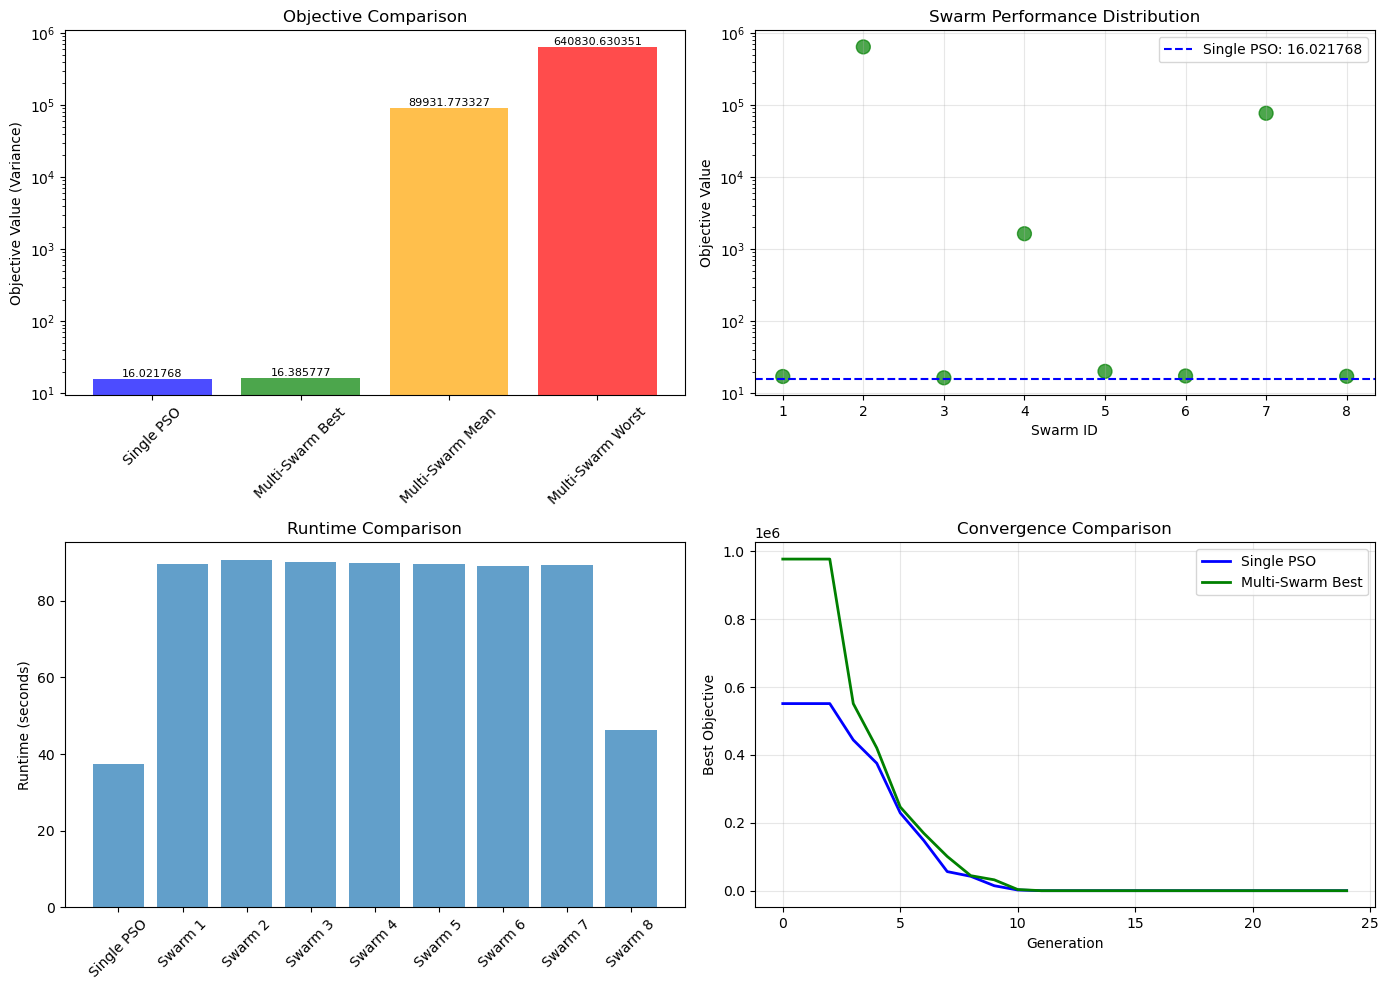


📊 MULTI-SWARM SUMMARY:
Performance:
• Best objective: 16.385777
• Mean objective: 89931.773327
• Std deviation: 209725.437250
• Range: 640814.244574

Robustness:
• Feasible swarms: 8/8
• Success rate: 100.0%
• Best improvement: 99.7%
• Mean improvement: -1313.8%

Efficiency:
• Total runtime: 145.5s
• Average per swarm: 18.2s
• Total search agents: 240


In [16]:
# =============================================================================
# Multi-Swarm Visualization and Analysis
# =============================================================================

print("=== MULTI-SWARM VISUALIZATION ===")

# Create comprehensive comparison plot - CHANGED: 2x2 grid instead of 2x3
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Single vs Multi-Swarm objective comparison
ax1 = axes[0, 0]
categories = ['Single PSO', 'Multi-Swarm Best', 'Multi-Swarm Mean', 'Multi-Swarm Worst']
values = [
    single_performance['objective'],
    min(all_objectives),
    np.mean(all_objectives),
    max(all_objectives)
]
colors = ['blue', 'green', 'orange', 'red']
bars = ax1.bar(categories, values, color=colors, alpha=0.7)
ax1.set_ylabel('Objective Value (Variance)')
ax1.set_yscale('log')
ax1.set_title('Objective Comparison')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value in zip(bars, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{value:.6f}', ha='center', va='bottom', fontsize=8)

# 2. Swarm performance distribution
ax2 = axes[0, 1]
swarm_ids = [s['swarm'] for s in swarm_summaries]
swarm_objectives = [s['objective'] for s in swarm_summaries]
feasible_colors = ['green' if s['feasible'] else 'red' for s in swarm_summaries]

scatter = ax2.scatter(swarm_ids, swarm_objectives, c=feasible_colors, s=100, alpha=0.7)
ax2.axhline(y=single_performance['objective'], color='blue', linestyle='--', 
           label=f'Single PSO: {single_performance["objective"]:.6f}')
ax2.set_xlabel('Swarm ID')
ax2.set_ylabel('Objective Value')
ax2.set_yscale('log')
ax2.set_title('Swarm Performance Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Runtime comparison
ax3 = axes[1, 0]
runtime_data = [single_performance['runtime']] + [s['time'] for s in swarm_summaries]
runtime_labels = ['Single PSO'] + [f'Swarm {i+1}' for i in range(len(swarm_summaries))]
ax3.bar(runtime_labels, runtime_data, alpha=0.7)
ax3.set_ylabel('Runtime (seconds)')
ax3.set_title('Runtime Comparison')
ax3.tick_params(axis='x', rotation=45)

# 4. Convergence comparison (if history available)
ax4 = axes[1, 1]
if hasattr(single_result, 'optimization_history') and single_result.optimization_history:
    history = single_result.optimization_history
    generations = [h['generation'] for h in history]
    objectives = [h['best_objective'] for h in history]
    ax4.plot(generations, objectives, 'b-', linewidth=2, label='Single PSO')

# Add multi-swarm best trajectory if available
if hasattr(multi_results.best_result, 'optimization_history') and multi_results.best_result.optimization_history:
    multi_history = multi_results.best_result.optimization_history
    multi_gens = [h['generation'] for h in multi_history]
    multi_objs = [h['best_objective'] for h in multi_history]
    ax4.plot(multi_gens, multi_objs, 'g-', linewidth=2, label='Multi-Swarm Best')

ax4.set_xlabel('Generation')
ax4.set_ylabel('Best Objective')
ax4.set_title('Convergence Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics separately
print(f"\n📊 MULTI-SWARM SUMMARY:")
print(f"Performance:")
print(f"• Best objective: {min(all_objectives):.6f}")
print(f"• Mean objective: {np.mean(all_objectives):.6f}")
print(f"• Std deviation: {np.std(all_objectives):.6f}")
print(f"• Range: {max(all_objectives) - min(all_objectives):.6f}")

print(f"\nRobustness:")
print(f"• Feasible swarms: {len(feasible_solutions)}/{len(swarm_summaries)}")
print(f"• Success rate: {len(feasible_solutions)/len(swarm_summaries):.1%}")
improvements = [s['improvement_vs_baseline'] for s in swarm_summaries]
print(f"• Best improvement: {max(improvements):.1f}%")
print(f"• Mean improvement: {np.mean(improvements):.1f}%")

print(f"\nEfficiency:")
print(f"• Total runtime: {multi_results.total_time:.1f}s")
print(f"• Average per swarm: {multi_results.total_time/len(swarm_summaries):.1f}s")
print(f"• Total search agents: {multi_swarm_config['n_runs'] * base_config['optimization']['algorithm']['pop_size']}")


=== FEASIBLE SOLUTIONS ANALYSIS ===
📊 Found 80 total feasible solutions across 8 swarms


/tmp/ipykernel_504609/960603887.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(swarm_objectives_list, labels=swarm_names)


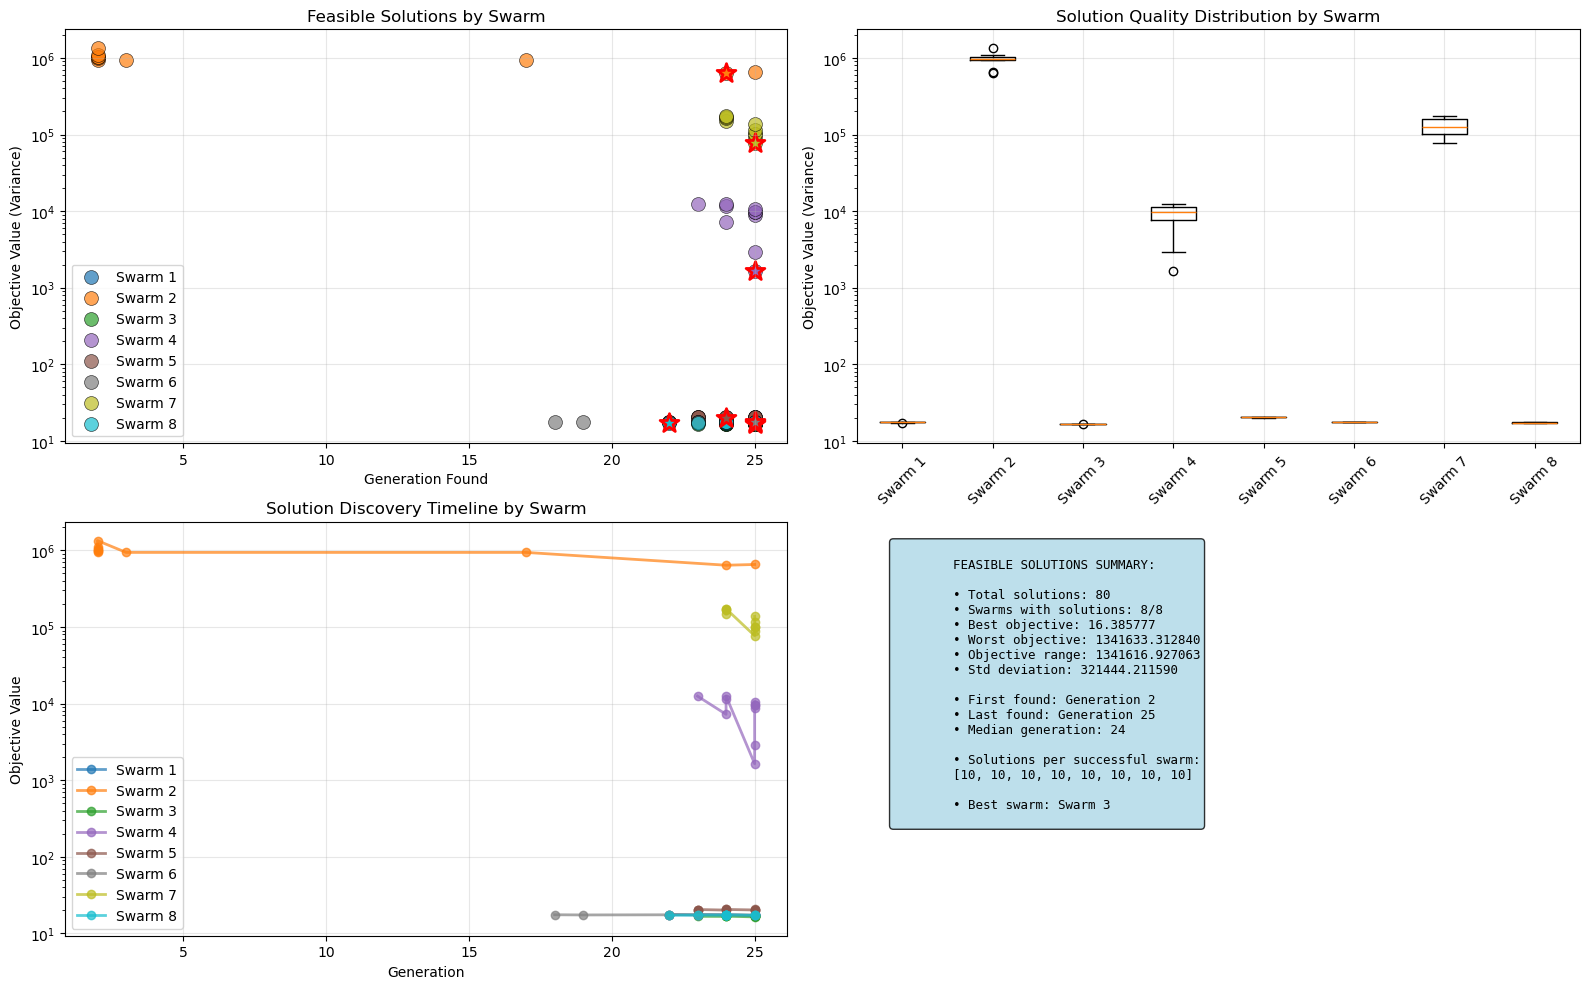


📋 SWARM COMPARISON SUMMARY:
Swarm  Solutions  Best Obj     Mean Obj     Std Dev    Best Gen
----------------------------------------------------------------------
1      10         17.086341    17.426711    0.156581   25      
2      10         640830.630351 960492.640986 192254.417597 24      
3      10         16.385777    16.677208    0.113717   25      
4      10         1637.524923  8717.687900  3584.412768 25      
5      10         20.120875    20.356843    0.127680   24      
6      10         17.367548    17.482758    0.076634   25      
7      10         76897.875276 127757.710417 33676.896444 25      
8      10         17.195526    17.312959    0.064627   22      


In [ ]:
# =============================================================================
# Feasible Solutions Scatter Plot Analysis
# =============================================================================

print("=== FEASIBLE SOLUTIONS ANALYSIS ===")

# Extract best feasible solutions from each swarm
if hasattr(multi_results, 'best_feasible_solutions_per_run') and multi_results.best_feasible_solutions_per_run:
    
    # Prepare data for scatter plot
    all_solutions = []
    swarm_colors = []
    best_per_swarm = []
    
    for swarm_idx, swarm_solutions in enumerate(multi_results.best_feasible_solutions_per_run):
        if swarm_solutions:  # Check if this swarm found feasible solutions
            for sol in swarm_solutions:
                all_solutions.append(sol)
                swarm_colors.append(swarm_idx)
            
            # Find best solution from this swarm
            best_solution = min(swarm_solutions, key=lambda x: x['objective'])
            best_per_swarm.append({
                'swarm_id': swarm_idx + 1,
                'solution': best_solution,
                'n_solutions': len(swarm_solutions)
            })
    
    if all_solutions:
        print(f"📊 Found {len(all_solutions)} total feasible solutions across {len(best_per_swarm)} swarms")
        
        # Extract data for plotting
        objectives = [sol['objective'] for sol in all_solutions]
        generations = [sol['generation_found'] for sol in all_solutions]
        
        # Create scatter plot
        plt.figure(figsize=(16, 10))
        
        # Main scatter plot - colored by swarm
        plt.subplot(2, 2, 1)
        unique_swarms = sorted(set(swarm_colors))
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_swarms)))

        for i, swarm_idx in enumerate(unique_swarms):
            mask = np.array(swarm_colors) == swarm_idx
            swarm_objectives = np.array(objectives)[mask]
            swarm_generations = np.array(generations)[mask]
            
            plt.scatter(swarm_generations, swarm_objectives,
                    c=[colors[i]], 
                    s=100, 
                    alpha=0.7,
                    edgecolors='black',
                    linewidth=0.5,
                    label=f'Swarm {swarm_idx + 1}')

        plt.xlabel('Generation Found')
        plt.ylabel('Objective Value (Variance)')
        plt.yscale('log')  # ADDED: Log scale for y-axis
        plt.title('Feasible Solutions by Swarm')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Highlight best solution from each swarm
        for best_info in best_per_swarm:
            best_sol = best_info['solution']
            swarm_color_idx = best_info['swarm_id'] - 1
            if swarm_color_idx in unique_swarms:
                color_idx = unique_swarms.index(swarm_color_idx)
                plt.scatter(best_sol['generation_found'], best_sol['objective'], 
                        s=200, marker='*', 
                        c=[colors[color_idx]],
                        edgecolors='red', linewidth=2)

        # Box plot by swarm
        plt.subplot(2, 2, 2)
        swarm_objectives_list = []
        swarm_names = []
        
        for swarm_idx, swarm_solutions in enumerate(multi_results.best_feasible_solutions_per_run):
            if swarm_solutions:
                swarm_objs = [sol['objective'] for sol in swarm_solutions]
                swarm_objectives_list.append(swarm_objs)
                swarm_names.append(f"Swarm {swarm_idx + 1}")
        
        if swarm_objectives_list:
            plt.boxplot(swarm_objectives_list, labels=swarm_names)
            plt.ylabel('Objective Value (Variance)')
            plt.yscale('log')
            plt.title('Solution Quality Distribution by Swarm')
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)

        # CHANGED: Solution discovery timeline - separate line per swarm
        plt.subplot(2, 2, 3)
        
        # Group solutions by swarm for timeline plotting
        for swarm_idx, swarm_solutions in enumerate(multi_results.best_feasible_solutions_per_run):
            if swarm_solutions:
                # Sort this swarm's solutions by generation
                sorted_swarm_solutions = sorted(swarm_solutions, key=lambda x: x['generation_found'])
                swarm_gens = [sol['generation_found'] for sol in sorted_swarm_solutions]
                swarm_objs = [sol['objective'] for sol in sorted_swarm_solutions]
                
                # Use consistent colors with other plots
                color_idx = unique_swarms.index(swarm_idx) if swarm_idx in unique_swarms else 0
                plt.plot(swarm_gens, swarm_objs, 'o-', 
                        color=colors[color_idx], 
                        alpha=0.7, 
                        linewidth=2,
                        markersize=6,
                        label=f'Swarm {swarm_idx + 1}')
        
        plt.xlabel('Generation')
        plt.ylabel('Objective Value')
        plt.yscale('log') 
        plt.title('Solution Discovery Timeline by Swarm')
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Statistics summary
        plt.subplot(2, 2, 4)
        plt.axis('off')
        
        stats_text = f"""
        FEASIBLE SOLUTIONS SUMMARY:
        
        • Total solutions: {len(all_solutions)}
        • Swarms with solutions: {len(best_per_swarm)}/{len(multi_results.best_feasible_solutions_per_run)}
        • Best objective: {min(objectives):.6f}
        • Worst objective: {max(objectives):.6f}
        • Objective range: {max(objectives) - min(objectives):.6f}
        • Std deviation: {np.std(objectives):.6f}
        
        • First found: Generation {min(generations)}
        • Last found: Generation {max(generations)}
        • Median generation: {np.median(generations):.0f}
        
        • Solutions per successful swarm:
        {[info['n_solutions'] for info in best_per_swarm]}
        
        • Best swarm: Swarm {best_per_swarm[np.argmin([info['solution']['objective'] for info in best_per_swarm])]['swarm_id']}
        """
        
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
                 fontsize=9, verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed swarm comparison
        print(f"\n📋 SWARM COMPARISON SUMMARY:")
        print(f"{'Swarm':<6} {'Solutions':<10} {'Best Obj':<12} {'Mean Obj':<12} {'Std Dev':<10} {'Best Gen':<8}")
        print("-" * 70)
        
        for best_info in best_per_swarm:
            swarm_idx = best_info['swarm_id'] - 1
            swarm_solutions = multi_results.best_feasible_solutions_per_run[swarm_idx]
            swarm_objectives = [sol['objective'] for sol in swarm_solutions]
            
            print(f"{best_info['swarm_id']:<6} {len(swarm_solutions):<10} "
                  f"{min(swarm_objectives):<12.6f} {np.mean(swarm_objectives):<12.6f} "
                  f"{np.std(swarm_objectives):<10.6f} {best_info['solution']['generation_found']:<8}")
    
    else:
        print("❌ No feasible solutions found across any swarms")
        
else:
    print("❌ No feasible solutions tracking data available")

You may notice from thend whisker plot that the multi_swarm has a wide range of solutions (some much better than others). Any of these solutions could have been the result of a signle PSO run, and so we could have found a very good or very bad solution. The multi_swarm approach gives us more chance of finding a good solution.

=== SPATIAL COMPARISON OF BEST SOLUTIONS ===
🗺️ Creating spatial comparison of best solutions from 8 swarms
📊 Consistent color scale: 0 to 401.0 vehicles per zone
🎨 Showing 6 solutions: Single PSO + best from each swarm
📊 Spatial lag calculated:
   Input mean: 26.22
   Spatial lag mean: 26.67
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 26.22
   Mean neighbor service: 26.67
   Mean accessibility: 31.55
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 40.04
   Spatial lag mean: 40.67
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 40.04
   Mean neighbor service: 40.67
   Mean accessibility: 48.17
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 28.62
   Spatial lag mean: 29.09
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 28.62
   Mean neighbor service: 29.09
   Mean accessibility: 34.44
   Zones with improved access: 244
📊 Spatial la

/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans

📊 Spatial lag calculated:
   Input mean: 22.17
   Spatial lag mean: 22.59
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 22.17
   Mean neighbor service: 22.59
   Mean accessibility: 26.69
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 32.14
   Spatial lag mean: 32.77
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 32.14
   Mean neighbor service: 32.77
   Mean accessibility: 38.69
   Zones with improved access: 244


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()


📊 Spatial lag calculated:
   Input mean: 27.11
   Spatial lag mean: 27.57
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 27.11
   Mean neighbor service: 27.57
   Mean accessibility: 32.63
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 39.52
   Spatial lag mean: 40.20
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 39.52
   Mean neighbor service: 40.20
   Mean accessibility: 47.56
   Zones with improved access: 244


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()


📊 Spatial lag calculated:
   Input mean: 27.81
   Spatial lag mean: 28.30
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 27.81
   Mean neighbor service: 28.30
   Mean accessibility: 33.47
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 41.10
   Spatial lag mean: 41.76
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 41.10
   Mean neighbor service: 41.76
   Mean accessibility: 49.45
   Zones with improved access: 244


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()


📊 Spatial lag calculated:
   Input mean: 30.56
   Spatial lag mean: 31.10
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 30.56
   Mean neighbor service: 31.10
   Mean accessibility: 36.78
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 43.01
   Spatial lag mean: 43.80
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 43.01
   Mean neighbor service: 43.80
   Mean accessibility: 51.77
   Zones with improved access: 244


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu

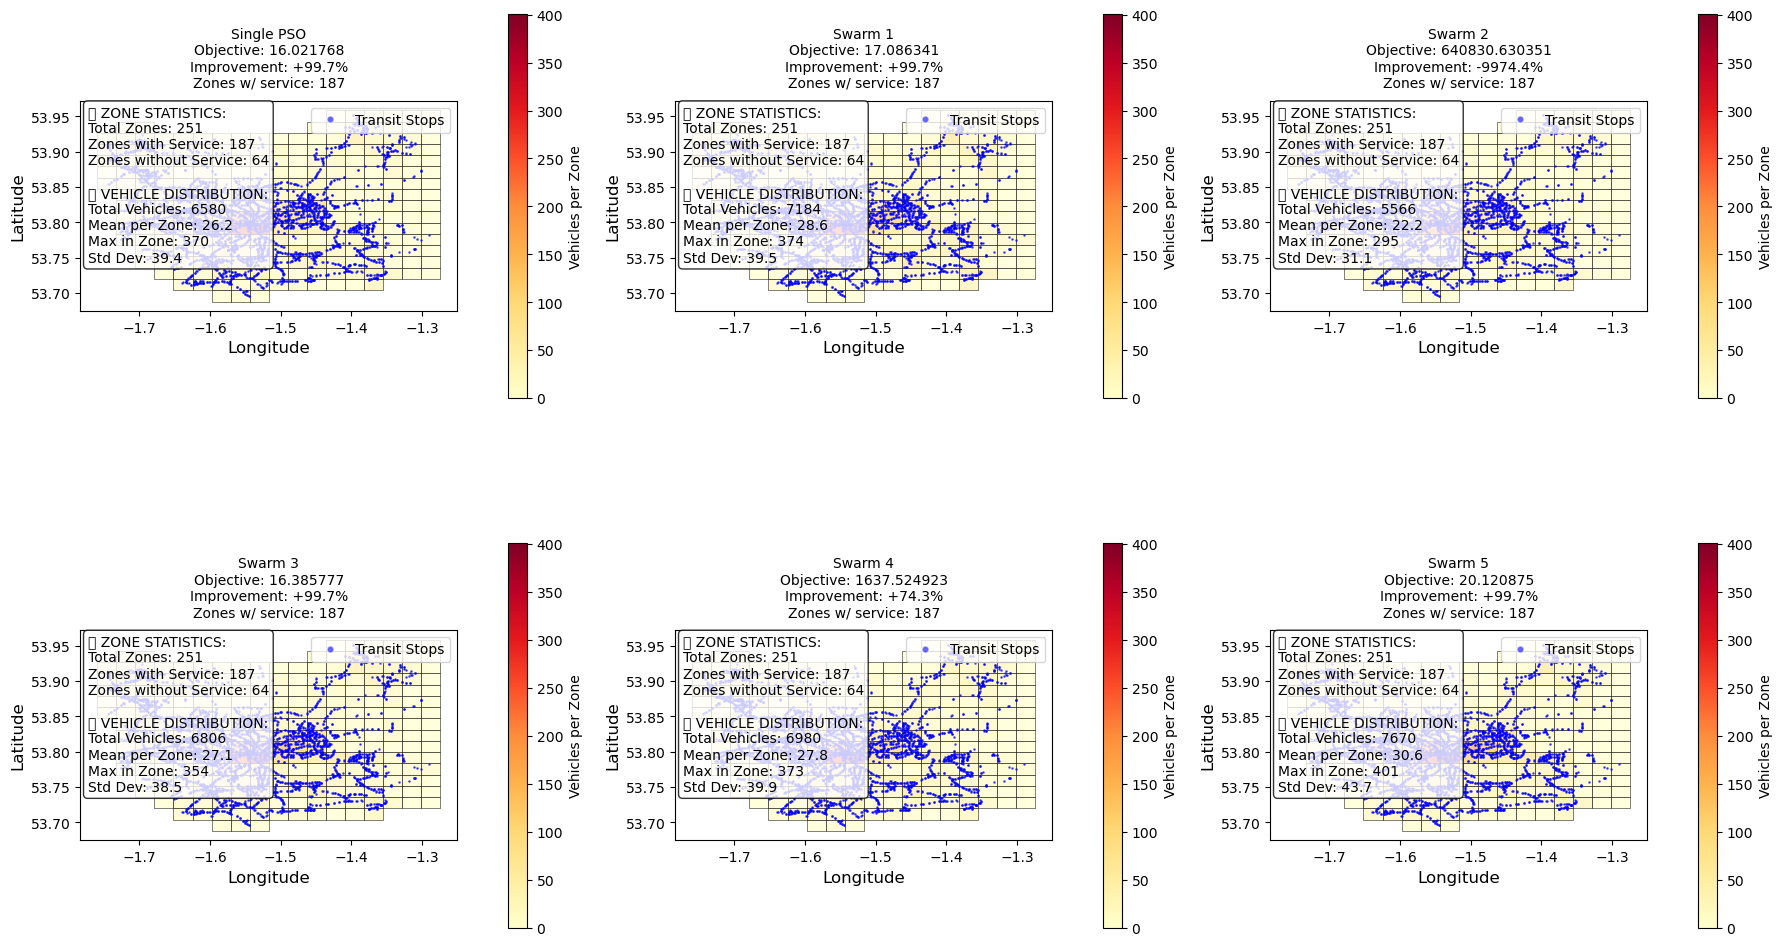


🎯 SPATIAL SOLUTION INSIGHTS:
   • Best solution: Single PSO
   • Objective range: 16.021768 to 640830.630351


In [11]:
# =============================================================================
# Spatial Comparison of Best Solutions
# =============================================================================

print("=== SPATIAL COMPARISON OF BEST SOLUTIONS ===")

# Check if we have best solutions for spatial mapping
if 'best_per_swarm' in locals() and best_per_swarm:
    print(f"🗺️ Creating spatial comparison of best solutions from {len(best_per_swarm)} swarms")
    
    # Calculate consistent color scale
    all_vehicles = []
    solutions_to_plot = []
    
    # Include single PSO result for comparison
    single_vehicles = coverage_objective.spatial_system._vehicles_per_zone(
        single_result.best_solution, opt_data
    )["average"]
    all_vehicles.append(single_vehicles)
    solutions_to_plot.append({
        'solution': single_result.best_solution,
        'name': 'Single PSO',
        'objective': single_result.best_objective,
        'swarm_id': 'Single'
    })
    
    # Add best solutions from each swarm
    for best_info in best_per_swarm:
        vehicles = coverage_objective.spatial_system._vehicles_per_zone(
            best_info['solution']['solution'], opt_data
        )["average"]
        all_vehicles.append(vehicles)
        solutions_to_plot.append({
            'solution': best_info['solution']['solution'],
            'name': f"Swarm {best_info['swarm_id']}",
            'objective': best_info['solution']['objective'],
            'swarm_id': best_info['swarm_id']
        })
    
    # Set consistent scale
    vmin = 0
    vmax = max(vehicles.max() for vehicles in all_vehicles)
    
    # Limit to 6 solutions for readability
    max_maps = min(6, len(solutions_to_plot))
    solutions_to_plot = solutions_to_plot[:max_maps]
    
    print(f"📊 Consistent color scale: 0 to {vmax:.1f} vehicles per zone")
    print(f"🎨 Showing {max_maps} solutions: Single PSO + best from each swarm")
    
    # Create subplot grid
    if max_maps <= 3:
        rows, cols = 1, max_maps
        figsize = (8 * cols, 6)
    else:
        rows, cols = 2, 3
        figsize = (18, 12)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Handle single subplot case
    if max_maps == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if hasattr(axes, '__len__') else [axes]
    else:
        axes = axes.flatten()
    
    # Plot each solution
    for i, sol_info in enumerate(solutions_to_plot):
        ax = axes[i]
        
        # Get detailed analysis
        sol_analysis = coverage_objective.get_detailed_analysis(sol_info['solution'])
        
        # Create the map
        coverage_objective.spatial_system.visualize_spatial_coverage(
            solution_matrix=sol_info['solution'],
            optimization_data=opt_data,
            figsize=None,
            ax=ax,
            show_stops=True,
            vmin=vmin,
            vmax=vmax
        )
        
        # Calculate improvement vs baseline
        improvement = ((current_objective_value - sol_info['objective']) / current_objective_value * 100)
        
        # Set title with key metrics
        title = (f"{sol_info['name']}\n"
                f"Objective: {sol_info['objective']:.6f}\n"
                f"Improvement: {improvement:+.1f}%\n"
                f"Zones w/ service: {sol_analysis['zones_with_service_average']}")
        
        ax.set_title(title, fontsize=10, pad=10)
    
    # Hide empty subplots
    for i in range(max_maps, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print spatial comparison summary
    print(f"\n🎯 SPATIAL SOLUTION INSIGHTS:")
    objectives = [sol['objective'] for sol in solutions_to_plot]
    print(f"   • Best solution: {solutions_to_plot[np.argmin(objectives)]['name']}")
    print(f"   • Objective range: {min(objectives):.6f} to {max(objectives):.6f}")    
else:
    print("❌ No best solutions available for spatial comparison")

In [12]:
# =============================================================================
# Summary and Recommendations
# =============================================================================

print(f"\n" + "="*80)
print(f"📋 MULTI-SWARM PSO ANALYSIS SUMMARY")
print(f"="*80)

print(f"\n🏆 PERFORMANCE COMPARISON:")
print(f"   Single PSO best objective: {single_performance['objective']:.6f}")
print(f"   Multi-swarm best objective: {multi_results.best_result.best_objective:.6f}")

if multi_results.best_result.best_objective < single_performance['objective']:
    improvement = ((single_performance['objective'] - multi_results.best_result.best_objective) / single_performance['objective'] * 100)
    print(f"   ✅ Multi-swarm advantage: {improvement:.1f}% better objective")
else:
    print(f"   🔄 Single PSO performed better in this run")

print(f"\n🎯 ROBUSTNESS ANALYSIS:")
if len(feasible_solutions) > 0:
    print(f"   ✅ Multi-swarm found {len(feasible_solutions)} swarms with feasible solutions")
    print(f"   📊 Success rate: {len(feasible_solutions)/len(swarm_summaries):.1%}")
    print(f"   📈 Solution diversity: {np.std(all_objectives):.6f} std deviation")
else:
    print(f"   ❌ No feasible solutions found - constraints too restrictive")

print(f"\n⏱️ EFFICIENCY ANALYSIS:")
print(f"   Single PSO runtime: {single_performance['runtime']:.1f} seconds")
print(f"   Multi-swarm total runtime: {multi_results.total_time:.1f} seconds")
print(f"   Average per swarm: {multi_results.total_time/len(swarm_summaries):.1f} seconds")
efficiency_ratio = multi_results.total_time / single_performance['runtime']
print(f"   Efficiency ratio: {efficiency_ratio:.1f}x runtime for multi-swarm")


📋 MULTI-SWARM PSO ANALYSIS SUMMARY

🏆 PERFORMANCE COMPARISON:
   Single PSO best objective: 16.021768
   Multi-swarm best objective: 16.385777
   🔄 Single PSO performed better in this run

🎯 ROBUSTNESS ANALYSIS:
   ✅ Multi-swarm found 8 swarms with feasible solutions
   📊 Success rate: 100.0%
   📈 Solution diversity: 209725.437250 std deviation

⏱️ EFFICIENCY ANALYSIS:
   Single PSO runtime: 37.3 seconds
   Multi-swarm total runtime: 145.5 seconds
   Average per swarm: 18.2 seconds
   Efficiency ratio: 3.9x runtime for multi-swarm
